In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats

import scipy
import pywt
import mne
from mne.decoding import CSP
import math

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeaveOneGroupOut

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder


from mne.time_frequency import AverageTFRArray

import sys
from tqdm import tqdm


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *
from wavelet_utils import *
from stats_utils import *
import glob
import os

from mne.time_frequency import AverageTFRArray
import seaborn as sns
import warnings

#warnings and logs
warnings.simplefilter(action='ignore', category=FutureWarning)
mne.set_log_level('CRITICAL')

Load data

In [301]:
task = 'listen'

epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data_n05to05_30Hz'
subjects_to_process = find_existing_subjects(epochs_dir)
#subjects_to_process = ['01','05']
n_subs = len(subjects_to_process)

print('processing subjects:', subjects_to_process)

processing subjects: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']


Concatenate subjects

In [302]:
def concat_epochs_subs(subjects_to_process, task, epochs_dir, period, drop_bads = True, **kwargs):
    """ 
    Concatenate epochs over multiple subjects. Use for CSP.
    drop_bads: whether to drop bad epochs according to some rejection criteria
    ---
    Returns: 
    eps_all: epochs object with concatenated epochs
    sub_labels: list of sub labels corresponding to each epoch in concatenated list e.g. [1,1,1,..2,2,...,n] 
    """
    eps_list = []
    sub_labels = [] #list of subs
    for sub in subjects_to_process: 
        #read epochs
        eps_file = os.path.join(epochs_dir, f'{task}_epochs_{period}_{sub}.fif')
        eps = mne.read_epochs(eps_file)

        #drop bad epochs
        if drop_bads:
            eps.drop_bad(**kwargs)
        eps_list.append(eps)
        
        

        #add sub labels for CV
        n_eps = eps.get_data().shape[0]
        sub_labels_sub = [sub]*n_eps
        sub_labels.extend(sub_labels_sub)

    
    #drop bad epochs
    eps_all = mne.concatenate_epochs(eps_list)
     


    return eps_all, sub_labels



In [303]:

reject_criteria = dict(eeg=100e-6) 
eps_all_pre, sub_labels_pre = concat_epochs_subs(subjects_to_process, task, epochs_dir, 'pre', reject = reject_criteria)
eps_all_post, sub_labels_post = concat_epochs_subs(subjects_to_process, task, epochs_dir, 'post', reject = reject_criteria)


Change pre/post labels 

(pre = 1, post = 2) and combine pre and post epochs

In [304]:

eps_all = mne.concatenate_epochs([eps_all_pre, eps_all_post]) #doesn't have the different labels, don't use these events

In [305]:
pre_labels = np.ones_like(eps_all_pre.events[:, 2])  
post_labels = np.full_like(eps_all_post.events[:, 2], 2) #the default value is already 2 for listening post

labels = np.hstack([pre_labels, post_labels]) #use this instead of events as labels for training
sub_labels = np.hstack([sub_labels_pre, sub_labels_post])
#combine epochs
eps_all = mne.concatenate_epochs([eps_all_pre, eps_all_post])

In [306]:
#mne.viz.plot_epochs_image(eps_all, combine = 'mean')

Define frequencies

In [307]:
# Classification & time-frequency parameters
tmin, tmax = -0.500, 0.5
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 3.0
max_freq = 30.0
n_freqs = 8  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freqs = np.round(freqs,2)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)

Make CV pipeline

In [308]:
# PARAMETERS
n_splits = 6  # for cross-validation, 5 is better, here we use 3 for speed
n_components = 4 #components of CSP to keep
iir_params = dict(order=8, ftype="butter") #for filtering frequencies

# Assemble the classifier using scikit-learn pipeline
clf = make_pipeline(
    CSP(n_components=n_components, reg=None, log=True, norm_trace=False),
    LinearDiscriminantAnalysis(),
)

# CV setup
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42) #use logo instead
logo = LeaveOneGroupOut()


### PLOT SPLITS
#X = eps_all.get_data()[:, :64, :]
#y = labels

#plot train, test splits
"""plt.figure(figsize = (20,5))
x_pos = 0
"""
#leave one out
"""
for train_idx, test_idx in logo.split(X, y, groups = sub_labels):
    #print(f'train indices: {train_idx}, test indices: {test_idx}')
    
    plt.eventplot(train_idx, color = 'grey', lineoffsets = x_pos)
    plt.eventplot(test_idx, color = 'orange', lineoffsets = x_pos)
    x_pos+=1"""

#CV 
"""for train_idx, test_idx in cv.split(X, y):
    #print(f'train indices: {train_idx}, test indices: {test_idx}')
    print(len(train_idx), len(test_idx))
    plt.eventplot(train_idx, color = 'grey', lineoffsets = x_pos)
    plt.eventplot(test_idx, color = 'orange', lineoffsets = x_pos)
    x_pos+=1

plt.xlim(1,400)"""

"for train_idx, test_idx in cv.split(X, y):\n    #print(f'train indices: {train_idx}, test indices: {test_idx}')\n    print(len(train_idx), len(test_idx))\n    plt.eventplot(train_idx, color = 'grey', lineoffsets = x_pos)\n    plt.eventplot(test_idx, color = 'orange', lineoffsets = x_pos)\n    x_pos+=1\n\nplt.xlim(1,400)"

CV and classification

In [309]:
#test on one frequency
#cross_val_score_freq = cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=logo, groups = sub_labels)



In [310]:
"""# Loop through each frequency range of interest
freq_scores = {}

for freq, (fmin, fmax) in enumerate(tqdm(freq_ranges)):

    eps_filt = eps_all.copy()
    eps_filt.filter(l_freq=fmin, h_freq=fmax, picks=None, method='iir', iir_params=iir_params, verbose=None)
    X = eps_filt.get_data(copy = True)[:, :64, :]
    y = labels


    # Save mean scores over folds for each frequency and time window
    cross_val_score_freq = cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=logo, groups = sub_labels)
    #cross_val_score_freq = cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv)

    freq_scores[f'{fmin}-{fmax}Hz'] = cross_val_score_freq

    #freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv), axis=0)
    print(f'{fmin}-{fmax}Hz', cross_val_score_freq)
    
savemat(f'freq_scores_logo_{task}.mat', freq_scores)"""

'# Loop through each frequency range of interest\nfreq_scores = {}\n\nfor freq, (fmin, fmax) in enumerate(tqdm(freq_ranges)):\n\n    eps_filt = eps_all.copy()\n    eps_filt.filter(l_freq=fmin, h_freq=fmax, picks=None, method=\'iir\', iir_params=iir_params, verbose=None)\n    X = eps_filt.get_data(copy = True)[:, :64, :]\n    y = labels\n\n\n    # Save mean scores over folds for each frequency and time window\n    cross_val_score_freq = cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=logo, groups = sub_labels)\n    #cross_val_score_freq = cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv)\n\n    freq_scores[f\'{fmin}-{fmax}Hz\'] = cross_val_score_freq\n\n    #freq_scores[freq] = np.mean(cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv), axis=0)\n    print(f\'{fmin}-{fmax}Hz\', cross_val_score_freq)\n    \nsavemat(f\'freq_scores_logo_{task}.mat\', freq_scores)'

In [329]:
mat_file = loadmat('freq_scores_cv_motor.mat')
freq_scores = {key: mat_file[key] for key in mat_file if not key.startswith('__')}


In [330]:
freq_scores

{'3.0-6.86Hz': array([[0.63786669, 0.61299726, 0.65618975, 0.63760247, 0.60018707,
         0.63422555]]),
 '6.86-10.71Hz': array([[0.65377705, 0.64583835, 0.66803266, 0.64693203, 0.65015853,
         0.64390081]]),
 '10.71-14.57Hz': array([[0.59403481, 0.59598797, 0.61076732, 0.61245707, 0.61304117,
         0.60182835]]),
 '14.57-18.43Hz': array([[0.62702634, 0.60111045, 0.63754259, 0.61719637, 0.61080058,
         0.60796985]]),
 '18.43-22.29Hz': array([[0.61866184, 0.62705415, 0.62653392, 0.62840595, 0.61279236,
         0.59948404]]),
 '22.29-26.14Hz': array([[0.59211845, 0.59063265, 0.60638993, 0.58411978, 0.63244007,
         0.58863663]]),
 '26.14-30.0Hz': array([[0.59111774, 0.56704529, 0.59609042, 0.60136058, 0.62383164,
         0.56620472]])}

In [331]:
freq_scores_mean = np.zeros(n_freqs-1)
for i, key in enumerate(freq_scores.keys()):
    freq_scores_mean[i] = np.mean(freq_scores[key])

In [312]:
#savemat(f'freq_scores_cv_{task}.mat', freq_scores)

In [333]:
freqs

array([ 3.  ,  6.86, 10.71, 14.57, 18.43, 22.29, 26.14, 30.  ])

Plotting scores

ValueError: x and y must be the same size

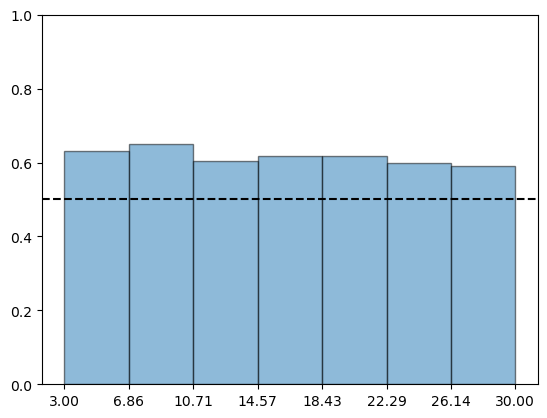

In [334]:
#plot mean scores for each freq
#plt.figure(figsize = (10,8))

freqs_xpos = averages = (freqs[:-1] + freqs[1:]) / 2

plt.bar(freqs[:-1], freq_scores_mean, width=np.diff(freqs)[0], align="edge", edgecolor="black", alpha = 0.5)
plt.xticks(freqs)
plt.ylim([0, 1])
plt.axhline(
    0.5, color="k", linestyle="--", label="chance level"
)

#plot points for each fold (should be each subject left out eventually)
for i, freq in enumerate(freq_scores.keys()):
    freq_range = freq_ranges[i]
    freq_toplot = np.mean(freq_range)
    freq_xpos = [freq_toplot]* freq_scores[freq].shape[0]
    plt.scatter(freq_xpos,freq_scores[freq], color = 'black')
"""
#plot for each sub
for idx in range(n_subs):
    freq_scores_idx = {key: value[idx] for key, value in freq_scores.items()}
    score = list(freq_scores_idx.values())
    plt.plot(freqs_xpos, score, 'o-', label=subjects_to_process[idx])"""

plt.legend(bbox_to_anchor = (1,1))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Decoding Scores")
plt.title(f"Frequency Decoding Scores, {task}")
plt.tight_layout()
#plt.ylim(0.4, 1)

Time-frequency decoding

In [314]:
# Classification & time-frequency parameters
tmin, tmax = -0.500, 0.5
n_cycles = 10.0  # how many complete cycles: used to define window size
min_freq = 3.0
max_freq = 30.0
n_freqs = 8  # how many frequency bins to use

# Assemble list of frequency range tuples
freqs = np.linspace(min_freq, max_freq, n_freqs)  # assemble frequencies
freqs = np.round(freqs,2)
freq_ranges = list(zip(freqs[:-1], freqs[1:]))  # make freqs list of tuples

# Infer window spacing from the max freq and number of cycles to avoid gaps
window_spacing = n_cycles / np.max(freqs) / 2.0
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
n_windows = len(centered_w_times)


# init scores
tf_scores = np.zeros((n_freqs - 1, n_windows))

freq_progress = tqdm(freq_ranges, desc="Frequency Progress", position=0, leave=True)

# Loop through each frequency range of interest
for freq, (fmin, fmax) in enumerate(freq_progress):
    # Infer window size based on the frequency being used
    w_size = n_cycles / ((fmax + fmin) / 2.0)  # in seconds

    print(w_size)

    eps_filt = eps_all.copy()
    eps_filt.filter(l_freq=fmin, h_freq=fmax, picks=None, method='iir', iir_params=iir_params, verbose=None)
    #X = eps_filt.get_data(copy = True)[:, :64, :]
    y = labels

    time_progress = tqdm(centered_w_times, desc="Time Progress", position=1, leave=False)
    # Roll covariance, csp and lda over time
    for t, w_time in enumerate(time_progress):
        # Center the min and max of the window
        w_tmin = w_time - w_size / 2.0
        w_tmax = w_time + w_size / 2.0

        # Crop data into time-window of interest
        X = eps_filt.get_data(tmin=w_tmin, tmax=w_tmax, copy=False)

        # Save mean scores over folds for each frequency and time window
        tf_scores[freq, t] = np.mean(
            cross_val_score(estimator=clf, X=X, y=y, scoring="roc_auc", cv=cv), axis=0
        )

Frequency Progress:   0%|          | 0/7 [00:00<?, ?it/s]

2.028397565922921


Frequency Progress:  14%|█▍        | 1/7 [12:27<1:14:44, 747.38s/it]

1.1383039271485487


Frequency Progress:  29%|██▊       | 2/7 [30:53<1:19:50, 958.15s/it]

0.7911392405063291


Frequency Progress:  43%|████▎     | 3/7 [40:53<52:58, 794.71s/it]  

0.6060606060606061


Frequency Progress:  57%|█████▋    | 4/7 [49:08<33:49, 676.47s/it]

0.4911591355599214


Frequency Progress:  71%|███████▏  | 5/7 [56:47<19:55, 597.88s/it]

0.41296716911005577


Frequency Progress:  86%|████████▌ | 6/7 [1:03:42<08:55, 535.94s/it]

0.3562522265764161


Frequency Progress: 100%|██████████| 7/7 [1:10:24<00:00, 603.48s/it]


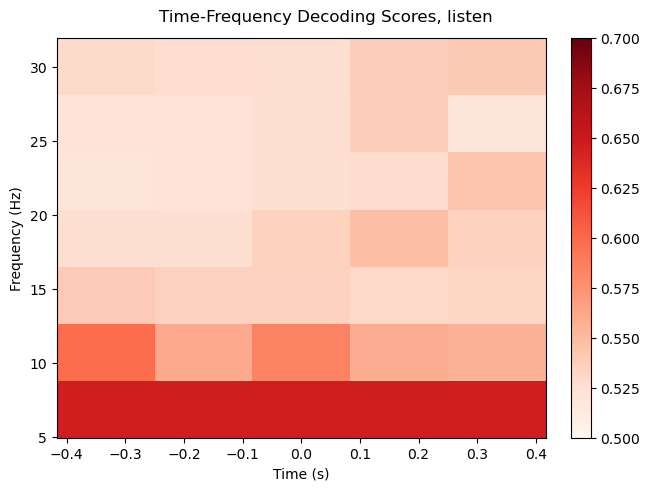

[<Figure size 640x480 with 2 Axes>]

In [325]:
# Set up time frequency object
av_tfr = AverageTFRArray(
    info=mne.create_info(["freq"], 128),
    data=tf_scores[np.newaxis, :],
    times=centered_w_times,
    freqs=freqs[1:],
    nave=1,
)

chance = np.mean(y)  # set chance level to white in the plot
av_tfr.plot(
    [0], vlim=(0.5, 0.7), title=f"Time-Frequency Decoding Scores, {task}", cmap=plt.cm.Reds
)

In [323]:
np.save(f'tf_scores_cv_{task}.npy', tf_scores)

Train on full dataset to see CSP patterns

In [ ]:
#ep_ex = mne.read_epochs('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_02.fif')

In [ ]:
"""
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
csp.fit_transform(eps_all.get_data(copy = True)[:,:64,:], labels)

ch_names_64, _ = load_channels()
eeg_ch_names = ch_names_64
new_info = mne.pick_info(ep_ex.info, sel=[ep_ex.info['ch_names'].index(ch) for ch in eeg_ch_names])
csp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)"""

'\ncsp = CSP(n_components=4, reg=None, log=True, norm_trace=False)\ncsp.fit_transform(eps_all.get_data(copy = True)[:,:64,:], labels)\n\nch_names_64, _ = load_channels()\neeg_ch_names = ch_names_64\nnew_info = mne.pick_info(ep_ex.info, sel=[ep_ex.info[\'ch_names\'].index(ch) for ch in eeg_ch_names])\ncsp.plot_patterns(new_info, ch_type="eeg", units="Patterns (AU)", size=1.5)'